Author: Iman Irajian ∞

Data: 18 Febuary, 2025

Email: [`iman.irajian@gmail.com`](mailto:iman.irajian@gmail.com?subject=GithubAnomalyDetection)

LinkedIn: [linkedin.com/in/imanirajian](https://linkedin.com/in/imanirajian)

___


Problem: Anomaly Detection

Model: Autoencoder

Dataset: ECG5000 [X ~ (5000 x 140)]

___

## Anomaly detection on ECG5000 dataset

An autoencoder will be trained to identify anomalies in the simplified version of the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)-([Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography)), a collection of 5,000 electrocardiograms, each comprising 140 data points.

For simplicity, the dataset has been modified such that each sample is assigned a binary label: `0` for abnormal heart rhythms and `1` for normal ones. The primary objective is to accurately detect irregular cardiac patterns. By focusing on anomaly detection, this approach offers a framework that can be extended to much larger datasets, where labeled data is scarce or unavailable. Such methodologies are particularly useful in real-world medical applications, where distinguishing between normal and abnormal physiological patterns is critical for early diagnosis and intervention.

Although the dataset is labeled, making it suitable for supervised learning, this example is designed to illustrate unsupervised anomaly detection techniques. In many practical scenarios, vast amounts of normal data are available, while abnormal cases remain relatively rare. Therefore, training a model purely on normal rhythms allows it to learn their typical patterns, making deviations easier to spot. The insights gained from this demonstration can be extrapolated to broader use cases, including fraud detection, industrial monitoring, and predictive maintenance, where anomalies often indicate critical failures or malfunctions.

The core principle behind this method lies in the functioning of autoencoders, which are trained to reconstruct input data with minimal error. Here, the autoencoder is exclusively trained on normal ECG patterns, enabling it to reconstruct them with high accuracy. When faced with abnormal rhythms, however, the model is expected to struggle, leading to a noticeably higher reconstruction error. By setting a predefined threshold, any instance exceeding this error margin is classified as an anomaly. This threshold-based approach ensures a systematic and quantifiable means of distinguishing normal and abnormal heart rhythms, reinforcing the efficacy of autoencoders in medical anomaly detection.

___
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from Helpers.ecg_helper import load_ecg_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist

from Models.AutoEncoders import AnomalyDetector

In [2]:
# Load the dataset
df, X, y, raw_data = load_ecg_data()

df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21
)

Normalize the data to `[0, 1]`.

In [4]:
min_val = tf.reduce_min(X_train)
max_val = tf.reduce_max(X_train)

X_train = (X_train - min_val) / (max_val - min_val)
X_test = (X_test - min_val) / (max_val - min_val)

X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

The autoencoder will be trained exclusively on normal rhythms, labeled as `1` in this dataset, ensuring a clear distinction between normal and abnormal heart patterns.

In [5]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_normal = X_train[y_train]
X_test_normal = X_test[y_test]

X_train_anomalous = X_train[~y_train]
X_test_anomalous = X_test[~y_test]

Plot ECG (normal)

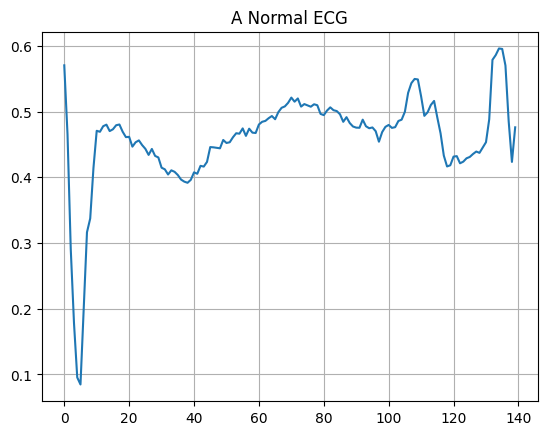

In [6]:
plt.figure()
plt.grid()
plt.plot(np.arange(140), X_train_normal[0])
plt.title("A Normal ECG")
plt.show()

Plot ECG (anomalous)

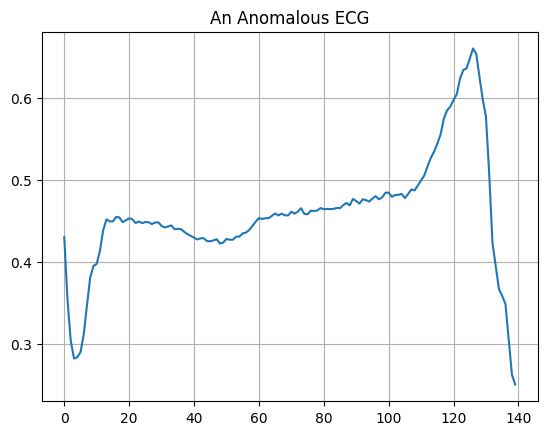

In [7]:
plt.figure()
plt.grid()
plt.plot(np.arange(140), X_train_anomalous[0])
plt.title("An Anomalous ECG")
plt.show()

### The model

In [8]:
autoencoder = AnomalyDetector()

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

It is important to note that while the autoencoder is trained solely on normal ECG patterns, its performance is evaluated on the entire test dataset, including both normal and abnormal rhythms.

In [10]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=30,
    batch_size=512,
    validation_data=(X_test, X_test),
    shuffle=True
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 501ms/step - loss: 0.0574 - val_loss: 0.0529
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0553 - val_loss: 0.0514
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0526 - val_loss: 0.0497
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0497 - val_loss: 0.0476
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0462 - val_loss: 0.0455
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0424 - val_loss: 0.0433
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0384 - val_loss: 0.0413
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0349 - val_loss: 0.0397
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0318 - val_loss: 0.0379
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0293 - val_loss: 0.0369
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0278 - val_loss: 0.0361
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0259 - val_loss: 0.0354


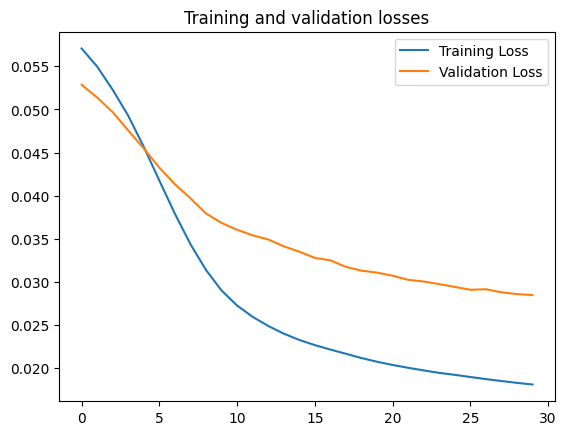

In [11]:
plt.figure()

plt.title("Training and validation losses")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.legend()
plt.show()

An ECG will be classified as anomalous if its reconstruction error exceeds one standard deviation from the normal training samples; to illustrate this, we will first visualize a normal ECG from the training set, its reconstructed version after passing through the autoencoder, and the corresponding reconstruction error.

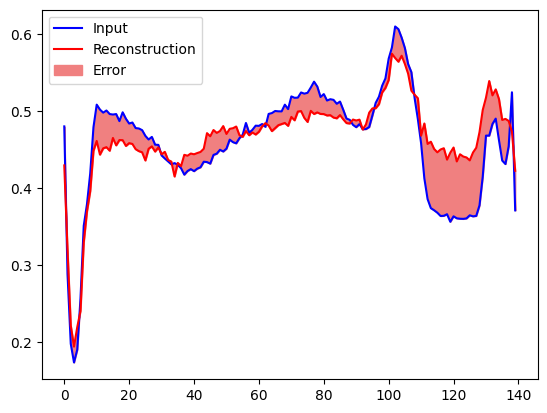

In [12]:
X_data_encoded = autoencoder.encoder(X_test_normal).numpy()
X_data_decoded = autoencoder.decoder(X_data_encoded).numpy()

plt.figure()

ix = 0

plt.title("")
plt.plot(X_test_normal[ix], 'blue')
plt.plot(X_data_decoded[ix], 'red')

plt.fill_between(np.arange(140), X_data_decoded[ix], X_test_normal[ix], color='lightcoral')

plt.legend(labels=["Input", "Reconstruction", "Error"])

plt.show()

Create a similar plot, this time for an anomalous test example.

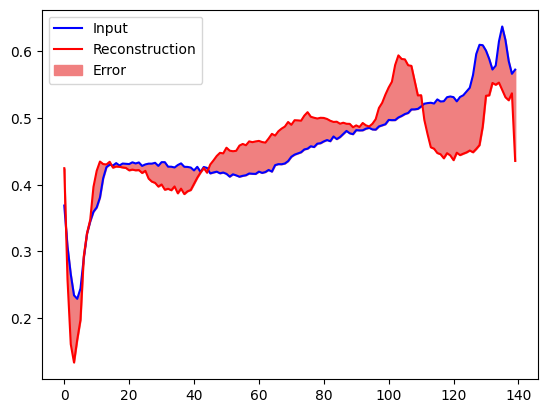

In [13]:
X_data_encoded = autoencoder.encoder(X_test_anomalous).numpy()
X_data_decoded = autoencoder.decoder(X_data_encoded).numpy()

plt.figure()

ix = 0

plt.plot(X_test_anomalous[ix], 'blue')
plt.plot(X_data_decoded[ix], 'red')

plt.fill_between(np.arange(140), X_data_decoded[ix], X_test_anomalous[ix], color='lightcoral')

plt.legend(labels=["Input", "Reconstruction", "Error"])

plt.show()

### Detect anomalies

Anomalies will be detected by determining whether the reconstruction loss exceeds a predefined threshold; the mean average error of normal training examples will be computed, and any future instance with a reconstruction error surpassing one standard deviation from this baseline will be classified as anomalous.


Plot the reconstruction error on normal ECGs from the training set

In [14]:
def show_and_get_loss(X, set_name, threshold=None):
  reconstructions = autoencoder.predict(X)
  loss = tf.keras.losses.mae(reconstructions, X)

  plt.figure()

  plt.hist(loss[None, :], bins=50)

  if (threshold):
    plt.axvline(threshold, c='r')

  plt.xlabel(f"{set_name} loss: Mean Squared Error")
  plt.ylabel("Frequency: Number of examples")
  plt.title(f"Loss of {set_name} set")

  plt.show()

  return loss

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


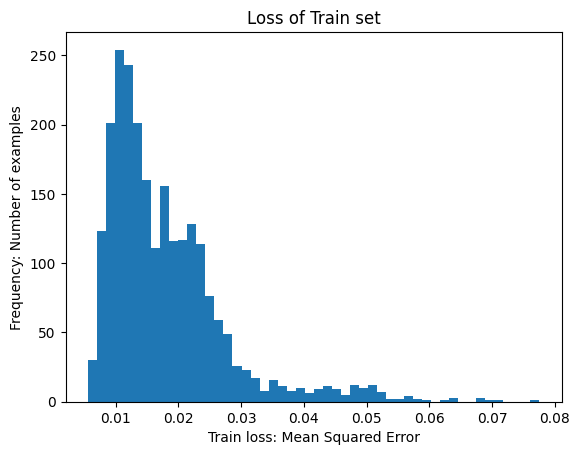

In [15]:
train_loss = show_and_get_loss(X_train_normal, "Train")

Choose a threshold value that is one standard deviations above the mean.

In [16]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.02760632


There are alternative methods for determining a threshold value beyond which test samples are identified as anomalies. The optimal approach will vary based on your dataset.

If you analyze the reconstruction error of anomalous instances in the test set, you'll observe that most exhibit a higher reconstruction error than the threshold. By adjusting the threshold, you can fine-tune the precision and recall of your classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


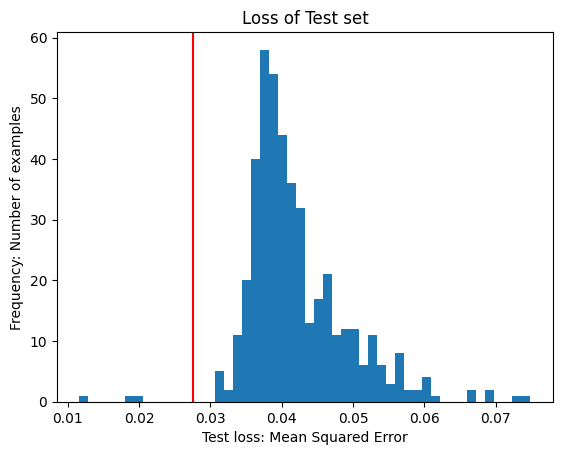

In [17]:
test_loss = show_and_get_loss(X_test_anomalous, "Test", threshold)

An ECG should be identified as an anomaly if its reconstruction error exceeds the threshold.

In [18]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [19]:
preds = predict(autoencoder, X_test, threshold)
print_stats(preds, y_test)

Accuracy = 0.936
Precision = 0.9940239043824701
Recall = 0.8910714285714286


∎
___
___

### Refrences:

1- Machine learning [Coursera] by Andrew Ng: https://www.coursera.org/learn/machine-learning

2- Pattern Recognition and Machine Learning by Christopher Bishop: https://www.springer.com/gp/book/9780387310732

3- [Deep Learning Book](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

4- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

___

Author: Iman Irajian ∞

Data: 18 Febuary, 2025

Email: [`iman.irajian@gmail.com`](mailto:iman.irajian@gmail.com?subject=GithubAnomalyDetection)

LinkedIn: [linkedin.com/in/imanirajian](https://linkedin.com/in/imanirajian)
